In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('cleaned_songs_data.csv')

In [4]:

#standard stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

#add artist names to stopwards
artist_names = df['artist_name'].unique()
for name in artist_names:
    words_in_name = name.lower().split()
    stop_words.update(words_in_name)

#adding additional miscellaneous terms and numbers to stopwords
additional_stopwords = ['feat', 'contributors', 'gillis', 'norma'] + [str(i) for i in range(10)]
stop_words.update(additional_stopwords)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ethan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [6]:
# Remove rows with missing values
df = df.dropna()


genres = ['country', 'hip_hop', 'rock', 'jazz', 'pop']

#remove and tracks not within the specified genres
df = df[df['genre'].isin(genres)]


In [7]:
def filter_lyrics(lyrics):

    words = lyrics.lower().split()
    filtered_words = [word for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(filtered_words)

#create new filtered_lyrics column
df['filtered_lyrics'] = df['lyrics'].apply(filter_lyrics)

In [8]:
#training and splitting data

X_train, X_test, y_train, y_test = train_test_split(df['filtered_lyrics'], df['genre'], test_size=0.2)


text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),
    ('clf', svm.SVC()),
])

text_clf.fit(X_train, y_train)

y_pred = text_clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     country       0.76      0.88      0.81        32
     hip_hop       1.00      0.95      0.97        41
        jazz       1.00      0.89      0.94        27
         pop       0.78      0.89      0.83        36
        rock       0.95      0.83      0.89        42

    accuracy                           0.89       178
   macro avg       0.90      0.89      0.89       178
weighted avg       0.90      0.89      0.89       178



In [9]:
# let the user input lyrics and predict the genre

lyrics = "I like big butts and I cannot lie"
predicted_genre = text_clf.predict([lyrics])
print(predicted_genre[0])

rock


In [10]:
# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')



Accuracy: 0.8876


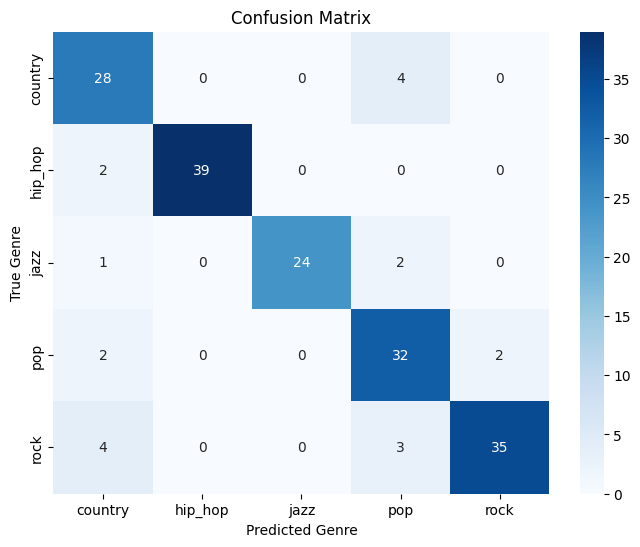

In [11]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=text_clf.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=text_clf.classes_,
            yticklabels=text_clf.classes_)
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
plt.title('Confusion Matrix')
plt.show()



In [12]:
# Perform cross-validation
scores = cross_val_score(text_clf, df['filtered_lyrics'], df['genre'], cv=5)
print(f'Cross-validation scores: {scores}')
print(f'Mean cross-validation score: {scores.mean():.4f}')

Cross-validation scores: [0.94382022 0.94382022 0.93820225 0.92090395 0.93220339]
Mean cross-validation score: 0.9358


In [13]:
from textblob import TextBlob

# Adding sentiment column for genre sentiment analysis
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

df['sentiment'] = df['filtered_lyrics'].apply(get_sentiment)

df.head().sort_values(by='sentiment')





,artist_name,track_name,genre,lyrics,filtered_lyrics,sentiment
2,David Bowie,Heroes,rock,"I, I will be king And you, you will be queen T...",though nothing drive away beat mean drink time...,-0.312500
4,Van Halen,Jump,rock,"Ow! I get up, and nothing gets me down You got...",nothing gets got seen toughest around feel got...,-0.266667
1,Led Zeppelin,Immigrant Song,rock,"​ (Two, three, four) Ahh! Ahh! We come from th...",come land ice snow midnight flow hammer gods d...,0.050000
0,Red Hot Chili Peppers,Can't Stop,rock,"Can't stop, addicted to the shindig Chop Top, ...",addicted shindig chop says gonna win big choos...,0.184722
3,Matchbox Twenty,Push,rock,"She said, ""I don't know if I've ever been good...",know ever good enough little bit rusty think h...,0.287500


In [14]:
# Display mean sentiment by genre
print(df.groupby('genre')['sentiment'].mean())


genre
country    0.093473
hip_hop   -0.022331
jazz       0.126168
pop        0.147846
rock       0.082544
Name: sentiment, dtype: float64


In [18]:

#minimum and maximum sentiments for each genre

min_sentiment = df.loc[df.groupby('genre')['sentiment'].idxmin()]

max_sentiment = df.loc[df.groupby('genre')['sentiment'].idxmax()]

print("Songs with Minimum Sentiment for Each Genre:")
print(min_sentiment[['genre', 'track_name', 'artist_name', 'sentiment']])

print("\nSongs with Maximum Sentiment for Each Genre:")
print(max_sentiment[['genre', 'track_name', 'artist_name', 'sentiment']])


Songs with Minimum Sentiment for Each Genre:
       genre       track_name   artist_name  sentiment
341  country     NO SAD SONGS     Niko Moon  -0.210827
305  hip_hop  Uber Everywhere     MadeinTYO  -0.566667
231     jazz     Body of Mine   Izo FitzRoy  -0.295833
173      pop     Shake It Off  Taylor Swift  -0.379592
98      rock            Loser          Beck  -0.550000

Songs with Maximum Sentiment for Each Genre:
       genre       track_name    artist_name  sentiment
360  country    The Good Ones  Gabby Barrett   0.528889
268  hip_hop  Ultralight Beam     Kanye West   0.600000
885     jazz         Attitude     Aloe Blacc   0.850000
147      pop  Best of My Love   The Emotions   0.575000
36      rock    Beautiful Day             U2   0.708333


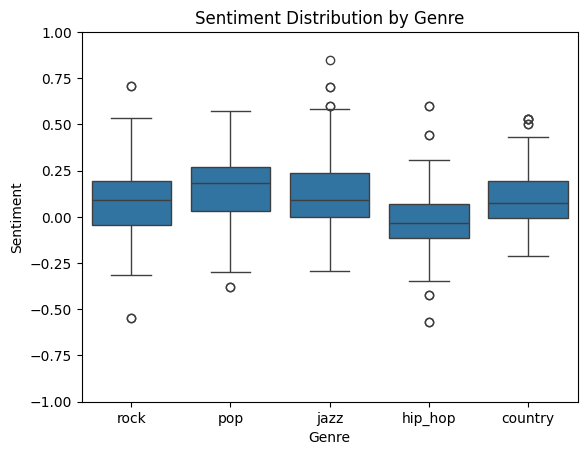

In [19]:
# Plot sentiment distribution by genre
sns.boxplot(x='genre', y='sentiment', data=df)
plt.ylim(-1, 1)
plt.title("Sentiment Distribution by Genre")
plt.xlabel("Genre")
plt.ylabel("Sentiment")
plt.show()


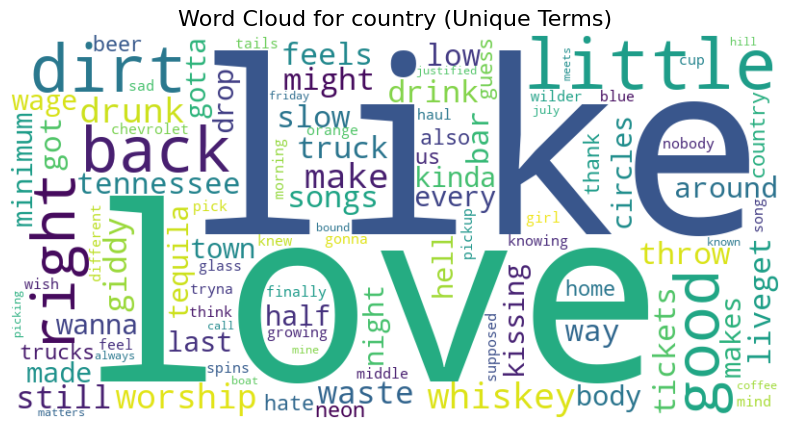

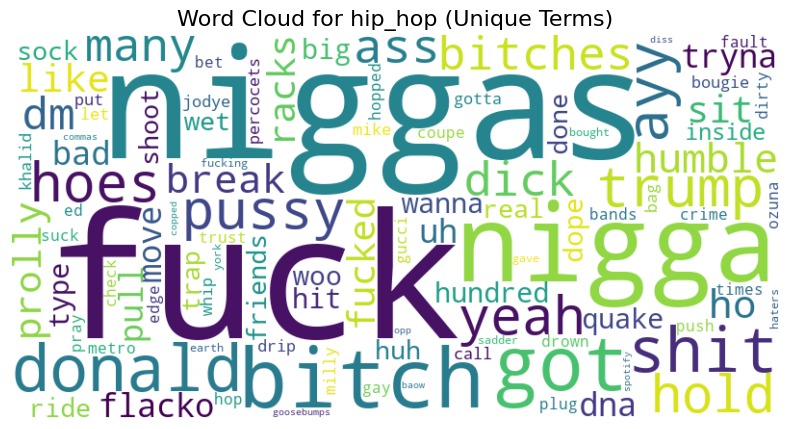

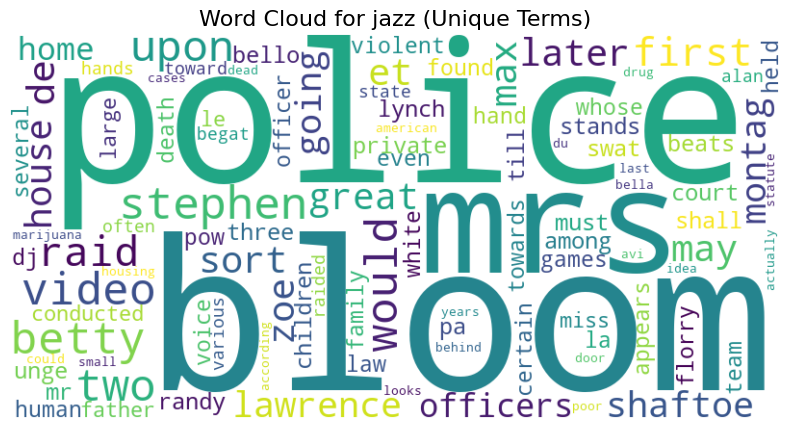

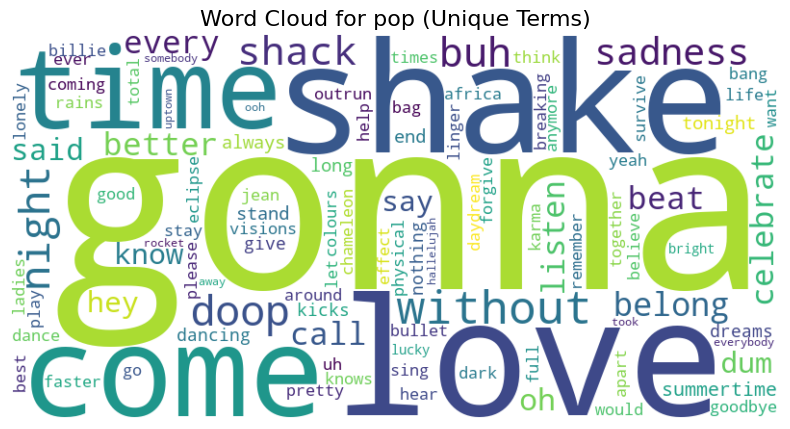

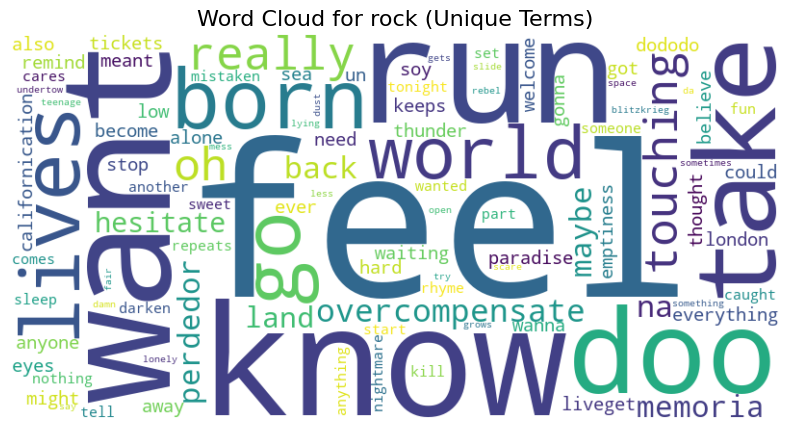

In [101]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

grouped = df.groupby('genre')['filtered_lyrics'].apply(' '.join)

vectorizer = TfidfVectorizer(stop_words=list(stop_words))
tfidf_matrix = vectorizer.fit_transform(grouped)
feature_names = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(tfidf_matrix.T.toarray(), index=feature_names, columns=grouped.index)

#extract unique terms for a specific genre
def get_unique_terms(target_genre, tfidf_df, top_n=100):
    target_scores = tfidf_df[target_genre]
    avg_scores = tfidf_df.drop(columns=target_genre).mean(axis=1)
    uniqueness = target_scores - avg_scores
    unique_terms = uniqueness.sort_values(ascending=False).head(top_n)
    return unique_terms

#generate and save word clouds for all genres
for genre in grouped.index:
    unique_terms = get_unique_terms(genre, tfidf_df)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(unique_terms.to_dict())
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {genre} (Unique Terms)", fontsize=16)
    plt.show()

